In [19]:
import sys
import os
import time
import threading
import utilities
import numpy as np
np.set_printoptions(suppress=True)

import collections 
if sys.version_info.major == 3 and sys.version_info.minor >= 10:
    from collections.abc import MutableMapping
else:
    from collections import MutableMapping

from kortex_api.autogen.client_stubs.BaseClientRpc import BaseClient
from kortex_api.autogen.client_stubs.BaseCyclicClientRpc import BaseCyclicClient
from kortex_api.autogen.client_stubs.ControlConfigClientRpc import ControlConfigClient

from kortex_api.autogen.messages import Base_pb2, BaseCyclic_pb2, Common_pb2

# Maximum allowed waiting time during actions (in seconds)
TIMEOUT_DURATION = 20

In [73]:
class TCPArguments:
    def __init__(self):
        self.ip = "192.168.0.10"
        self.username = "admin"
        self.password = "admin"


def check_for_end_or_abort(e):
    """Return a closure checking for END or ABORT notifications

    Arguments:
    e -- event to signal when the action is completed
        (will be set when an END or ABORT occurs)
    """
    def check(notification, e = e):
        print("EVENT : " + \
              Base_pb2.ActionEvent.Name(notification.action_event))
        if notification.action_event == Base_pb2.ACTION_END \
        or notification.action_event == Base_pb2.ACTION_ABORT:
            e.set()
    return check


def move_to_home_position(base):
    TIMEOUT_DURATION = 10  # in seconds
    # Make sure the arm is in Single Level Servoing mode (high-level mode)
    base_servo_mode = Base_pb2.ServoingModeInformation()
    base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
    base.SetServoingMode(base_servo_mode)
    
    # Move arm to ready position
    print("Moving the arm to home position")
    action_type = Base_pb2.RequestedActionType()
    action_type.action_type = Base_pb2.REACH_JOINT_ANGLES
    action_list = base.ReadAllActions(action_type)
    action_handle = None
    for action in action_list.action_list:
        if action.name == "L_Home":
            action_handle = action.handle

    if action_handle == None:
        print("Can't reach safe position. Exiting")
        return False

    e = threading.Event()
    notification_handle = base.OnNotificationActionTopic(
        check_for_end_or_abort(e),
        Base_pb2.NotificationOptions()
    )

    base.ExecuteActionFromReference(action_handle)
    finished = e.wait(TIMEOUT_DURATION)
    base.Unsubscribe(notification_handle)

    if finished:
        print("home position reached")
    else:
        print("Timeout on action notification wait")
    return finished


def move_tool_pose_relative(base, base_cyclic, pose_kinova):
    # move the end effector to a relative position of the current pose
    # pose_kinova is [x,y,z,theta_x,theta_y,theta_z] in meters and degrees
    print("Starting tool_pose relative movement ...")
    action = Base_pb2.Action()
    action.name = "Tool Pose Relative Movement"
    action.application_data = ""
    TIMEOUT_DURATION = 10  # in seconds

    feedback = base_cyclic.RefreshFeedback()

    cartesian_pose = action.reach_pose.target_pose
    cartesian_pose.x = feedback.base.tool_pose_x + pose_kinova[0]    # (meters)
    cartesian_pose.y = feedback.base.tool_pose_y + pose_kinova[1]    # (meters)
    cartesian_pose.z = feedback.base.tool_pose_z + pose_kinova[2]    # (meters)
    cartesian_pose.theta_x = feedback.base.tool_pose_theta_x + pose_kinova[3] # (degrees)
    cartesian_pose.theta_y = feedback.base.tool_pose_theta_y + pose_kinova[4] # (degrees)
    cartesian_pose.theta_z = feedback.base.tool_pose_theta_z + pose_kinova[5] # (degrees)

    e = threading.Event()
    notification_handle = base.OnNotificationActionTopic(
        check_for_end_or_abort(e),
        Base_pb2.NotificationOptions()
    )

    print("Executing action")
    base.ExecuteAction(action)

    print("Waiting for movement to finish ...")
    finished = e.wait(TIMEOUT_DURATION)
    base.Unsubscribe(notification_handle)

    if finished:
        print("tool_pose relative movement completed")
    else:
        print("Timeout on action notification wait")
    return finished


def move_end_effector(base, desired_pose):
    ### function for Kinova Gen3 7 dof on Kortex API
    ### Fundation for vel control code, can correct both pos and ang error at the same time
    ### Author: Chuizheng Kong
    ### Created on: 05/09/2024
    
    max_vel = 0.5-0.1  # m/s  0.5 is max
    #max_vel = 0.1
    max_w = 70.0  # ~ 50 deg/s
    kp_pos = 2.5
    kp_ang = 4.0

    dcc_range = max_vel / (kp_pos * 2)  # dcc_range should be smaller than max_vel/kp_pos
    ang_dcc_range = max_w / (kp_ang * 6)
    
    # Make sure the arm is in Single Level Servoing mode (high-level mode)
    base_servo_mode = Base_pb2.ServoingModeInformation()
    base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
    base.SetServoingMode(base_servo_mode)

    # init_pose = base.GetMeasuredCartesianPose()
    # get the desired rotation matrix
    R_d = getRotMtx(desired_pose)
    
    command = Base_pb2.TwistCommand()
    # note that twist is naturally in tool frame, but this conversion made things a bit easy
    command.reference_frame = Base_pb2.CARTESIAN_REFERENCE_FRAME_BASE
    command.duration = 0

    twist = command.twist
    twist.linear_x = 0.0  # adjust linear velocity
    twist.linear_y = 0.0
    twist.linear_z = 0.0
    twist.angular_x = 0.0
    twist.angular_y = 0.0
    twist.angular_z = 0.0  # adjust angular velocity

    max_exe_time = 10  # sec
    eps_pos = 0.001  # convergence criterion
    eps_ang = 0.01
    t_start = time.time()
    while True:
        current_pose = base.GetMeasuredCartesianPose()
        R = getRotMtx(current_pose)
        
        # reducing the pos error (in global frame!!)
        pos_diff = np.array([desired_pose.x-current_pose.x,
                             desired_pose.y-current_pose.y,
                             desired_pose.z-current_pose.z])
        
        pos_diff_norm = np.linalg.norm(pos_diff)
        v_temp = max_vel * pos_diff/pos_diff_norm

        # reducing ang error using ER = RRd^T
        ER = R @ R_d.T
        # frobenius norm of matrix squre root of ER or eR2
        k,theta = R2rot(ER)
        k=np.array(k)
        eR2=-np.sin(theta/2)*k * 180 / np.pi  # not the best name but works fine
        
        eR2_norm = np.linalg.norm(eR2)+1e-5
        w_temp = max_w * eR2/eR2_norm

        # print(pos_diff_norm, eR2_norm)

        reached = pos_diff_norm < eps_pos and eR2_norm < eps_ang
        
        if reached or time.time()>t_start+max_exe_time:
            print("Robot Stop")
            if reached:
                print("Goal Pose reached")
            base.Stop()
            break
            
        # go in max vel when outside dcc_range
        if pos_diff_norm < dcc_range:
            v = kp_pos * pos_diff
        else:
            v = v_temp

        if eR2_norm < ang_dcc_range:
            kR = kp_ang*np.eye(3)
            w = kR @ eR2 
        else:
            w = w_temp
            
        twist.linear_x = v[0]
        twist.linear_y = v[1] 
        twist.linear_z = v[2]
        twist.angular_x = w[0]
        twist.angular_y = w[1]
        twist.angular_z = w[2]
        base.SendTwistCommand(command)
        #time.sleep(0.025)  # 40 Hz high-level control loop freq (ok might not need)
    return True

!!!!!!! ROBOT MOVING!!!!!!TO HOME!!!!!

In [74]:
class TCPArguments:
    def __init__(self):
        self.ip = "192.168.1.10"
        self.username = "admin"
        self.password = "admin"

args = TCPArguments()
# Create connection to the device and get the router
with utilities.DeviceConnection.createTcpConnection(args) as router:

    # Create required services
    base = BaseClient(router)
    base_cyclic = BaseCyclicClient(router)

    current_pose = base.GetMeasuredCartesianPose()
    current_angles = base.GetMeasuredJointAngles()
    print("End-effector poses (pos, ori)\n",current_pose)
    # print("Joint angles\n", current_angles)
    
    # Example core
    success = True

    success &= move_to_home_position(base)

    # print the joint angles and end effector poses
    #print(base.ComputeForwardKinematics(current_angles))

    feedback = base_cyclic.RefreshFeedback()
    cartesian_pose = current_pose
    cartesian_pose.x = feedback.base.tool_pose_x    # (meters)
    cartesian_pose.y = feedback.base.tool_pose_y    # (meters)
    cartesian_pose.z = feedback.base.tool_pose_z    # (meters)
    cartesian_pose.theta_x = feedback.base.tool_pose_theta_x  # (degrees)
    cartesian_pose.theta_y = feedback.base.tool_pose_theta_y  # (degrees)
    cartesian_pose.theta_z = feedback.base.tool_pose_theta_z  # (degrees)
    
    print("Cyclic Feedback Pose: \n", cartesian_pose)

    #max_vel = base.GetTwistHardLimitation().linear
    #print("Twist Limit:\n", max_vel)
    

KeyboardInterrupt: 

!!!!!!! ROBOT MOVING!!!!!!TO +Y!!!!!

In [ ]:
with utilities.DeviceConnection.createTcpConnection(args) as router:

    # Create required services
    base = BaseClient(router)
    base_cyclic = BaseCyclicClient(router)
    
    pose = base.GetMeasuredCartesianPose()
    pose.y = pose.y - 0.3  # meters
    pose.theta_x = pose.theta_x - 30.0 # degrees
    
    print("target\n", pose)
    success = True
    success &= move_end_effector(base, pose)

    # print the joint angles and end effector poses
    current_pose = base.GetMeasuredCartesianPose()
    current_angles = base.GetMeasuredJointAngles()
    print("End-effector poses (pos, ori)\n",current_pose)

Logging as admin on device 192.168.1.10
target
 x: 0.45845118165016174
y: -0.2997697078215424
z: 0.43717965483665466
theta_x: 59.792396545410156
theta_y: -1.1725366115570068
theta_z: 89.724365234375

Robot Stop
Goal Pose reached
End-effector poses (pos, ori)
 x: 0.45846468210220337
y: -0.2996788024902344
z: 0.43722471594810486
theta_x: 59.78170394897461
theta_y: -1.1764131784439087
theta_z: 89.73845672607422



Move relatively

In [ ]:
with utilities.DeviceConnection.createTcpConnection(args) as router:

    # Create required services
    base = BaseClient(router)
    base_cyclic = BaseCyclicClient(router)
    pose = np.array([-0.01, 0.1,0.01,0,0,0])
    move_tool_pose_relative(base, base_cyclic, pose)

Logging as admin on device 192.168.1.10
Starting tool_pose relative movement ...
Executing action
Waiting for movement to finish ...
EVENT : ACTION_START
EVENT : ACTION_END
tool_pose relative movement completed


# Torque Control

In [101]:
from kortex_api.autogen.client_stubs.ActuatorConfigClientRpc import ActuatorConfigClient
from kortex_api.autogen.client_stubs.ActuatorCyclicClientRpc import ActuatorCyclicClient
from kortex_api.autogen.client_stubs.BaseClientRpc import BaseClient
from kortex_api.autogen.client_stubs.BaseCyclicClientRpc import BaseCyclicClient
from kortex_api.autogen.client_stubs.DeviceConfigClientRpc import DeviceConfigClient
from kortex_api.autogen.client_stubs.DeviceManagerClientRpc import DeviceManagerClient
from kortex_api.autogen.messages import Session_pb2, ActuatorConfig_pb2, Base_pb2, BaseCyclic_pb2, Common_pb2
from kortex_api.RouterClient import RouterClientSendOptions

import time
import sys
import threading

class TCPArguments:
    def __init__(self):
        self.ip = "192.168.0.10"
        self.username = "admin"
        self.password = "admin"

class TorqueExample:
    def __init__(self, router, router_real_time, torque_gain=2.0):

        # Maximum allowed waiting time during actions (in seconds)
        self.ACTION_TIMEOUT_DURATION = 20

        self.torque_amplification = torque_gain  # Torque measure on last actuator is sent as a command to first actuator

        # Create required services
        device_manager = DeviceManagerClient(router)
        
        self.actuator_config = ActuatorConfigClient(router)
        self.base = BaseClient(router)
        self.base_cyclic = BaseCyclicClient(router_real_time)

        self.base_command = BaseCyclic_pb2.Command()
        self.base_feedback = BaseCyclic_pb2.Feedback()
        self.base_custom_data = BaseCyclic_pb2.CustomData()

        # Detect all devices
        device_handles = device_manager.ReadAllDevices()
        self.actuator_count = self.base.GetActuatorCount().count

        # Only actuators are relevant for this example
        for handle in device_handles.device_handle:
            if handle.device_type == Common_pb2.BIG_ACTUATOR or handle.device_type == Common_pb2.SMALL_ACTUATOR:
                self.base_command.actuators.add()
                self.base_feedback.actuators.add()

        # Change send option to reduce max timeout at 3ms
        self.sendOption = RouterClientSendOptions()
        self.sendOption.andForget = False
        self.sendOption.delay_ms = 0
        self.sendOption.timeout_ms = 3

        self.cyclic_t_end = 30  #Total duration of the thread in seconds. 0 means infinite.
        self.cyclic_thread = {}

        self.kill_the_thread = False
        self.already_stopped = False
        self.cyclic_running = False

        # joint in control
        self.device_id = 3

        # Store the torque values
        self.time_stamp_sec = []
        self.first_link_torque = []

        # store impedance control parameters
        self._theta = []
        self._theta_dot = []
        self._theta_ddot = []
        self._theta_des = []
        self._tau = []

        # collision angle
        self.collision_angle = None

    # Create closure to set an event after an END or an ABORT
    def check_for_end_or_abort(self, e):
        """Return a closure checking for END or ABORT notifications

        Arguments:
        e -- event to signal when the action is completed
            (will be set when an END or ABORT occurs)
        """
        def check(notification, e = e):
            print("EVENT : " + \
                Base_pb2.ActionEvent.Name(notification.action_event))
            if notification.action_event == Base_pb2.ACTION_END \
            or notification.action_event == Base_pb2.ACTION_ABORT:
                e.set()
        return check

    def MoveToHomePosition(self):
        # Make sure the arm is in Single Level Servoing mode
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
    
        # Move arm to ready position
        print("Moving the arm to a safe position")
        action_type = Base_pb2.RequestedActionType()
        action_type.action_type = Base_pb2.REACH_JOINT_ANGLES
        action_list = self.base.ReadAllActions(action_type)
        action_handle = None
        for action in action_list.action_list:
            if action.name == "L_Home":
                action_handle = action.handle

        if action_handle == None:
            print("Can't reach safe position. Exiting")
            return False

        e = threading.Event()
        notification_handle = self.base.OnNotificationActionTopic(
            self.check_for_end_or_abort(e),
            Base_pb2.NotificationOptions()
        )

        self.base.ExecuteActionFromReference(action_handle)

        print("Waiting for movement to finish ...")
        finished = e.wait(self.ACTION_TIMEOUT_DURATION)
        self.base.Unsubscribe(notification_handle)

        if finished:
            print("Cartesian movement completed")
        else:
            print("Timeout on action notification wait")
        return finished

        return True

    def InitCyclic(self, sampling_time_cyclic=0.001, t_end=30, print_stats=False, target_func=None):

        if self.cyclic_running:
            return True

        # Move to Home position first
        if not self.MoveToHomePosition():
            return False

        print("Init Cyclic")
        sys.stdout.flush()

        base_feedback = self.SendCallWithRetry(self.base_cyclic.RefreshFeedback, 3)
        if base_feedback:
            self.base_feedback = base_feedback

            # Init command frame
            for x in range(self.actuator_count):
                self.base_command.actuators[x].flags = 1  # servoing
                self.base_command.actuators[x].position = self.base_feedback.actuators[x].position

            # First actuator is going to be controlled in torque
            # To ensure continuity, torque command is set to measure
            self.base_command.actuators[0].torque_joint = self.base_feedback.actuators[0].torque

            # Set arm in LOW_LEVEL_SERVOING
            base_servo_mode = Base_pb2.ServoingModeInformation()
            base_servo_mode.servoing_mode = Base_pb2.LOW_LEVEL_SERVOING
            self.base.SetServoingMode(base_servo_mode)

            # Send first frame
            self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)

            # Set first actuator in torque mode now that the command is equal to measure
            control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
            control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('TORQUE')
            # self.device_id = 3  # first actuator as id = 1

            self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)

            # Init cyclic thread
            self.cyclic_t_end = t_end
            self.cyclic_thread = threading.Thread(target=target_func, args=(sampling_time_cyclic, print_stats))
            self.cyclic_thread.daemon = True
            self.cyclic_thread.start()
            return True

        else:
            print("InitCyclic: failed to communicate")
            return False

    def RunCyclic(self, t_sample, print_stats):
        self.cyclic_running = True
        print("Run Cyclic")
        sys.stdout.flush()
        cyclic_count = 0  # Counts refresh
        stats_count = 0  # Counts stats prints
        failed_cyclic_count = 0  # Count communication timeouts

        # Initial delta between first and last actuator
        init_delta_position = self.base_feedback.actuators[0].position - self.base_feedback.actuators[self.actuator_count - 1].position
        print("init_delta_position: ", init_delta_position)

        # Initial first and last actuator torques; avoids unexpected movement due to torque offsets
        init_last_torque = self.base_feedback.actuators[self.actuator_count - 1].torque
        init_first_torque = -self.base_feedback.actuators[self.device_id-1].torque  # Torque measure is reversed compared to actuator direction
        print("init_last_torque: ", init_last_torque)
        print("init_first_torque: ", init_first_torque)

        t_now = time.time()
        t_cyclic = t_now  # cyclic time
        t_stats = t_now  # print  time
        t_init = t_now  # init   time

        print("Running torque control example for {} seconds".format(self.cyclic_t_end))

        while not self.kill_the_thread:
            t_now = time.time()

            # Cyclic Refresh
            if (t_now - t_cyclic) >= t_sample:
                t_cyclic = t_now
                # Position command to first actuator is set to measured one to avoid following error to trigger
                # Bonus: When doing this instead of disabling the following error, if communication is lost and first
                #        actuator continue to move under torque command, resulting position error with command will
                #        trigger a following error and switch back the actuator in position command to hold its position

                self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position
                # print("Running Position: ", self.base_command.actuators[0].position)

                # First actuator torque command is set to last actuator torque measure times an amplification
                # self.base_command.actuators[0].torque_joint = init_first_torque + \
                    # self.torque_amplification * (self.base_feedback.actuators[self.actuator_count - 1].torque - init_last_torque)

                print("Running Torque: ", self.base_feedback.actuators[self.device_id-1].torque)
                self.first_link_torque.append(self.base_feedback.actuators[self.device_id-1].torque)
                self.base_command.actuators[self.device_id-1].torque_joint = self.torque_amplification*self.base_feedback.actuators[self.device_id-1].torque
                self.time_stamp_sec.append(t_now-t_init)
                
                # self.base_command.actuators[0].torque_joint = init_first_torque + \
                #     self.torque_amplification * (self.base_feedback.actuators[0].torque - init_first_torque)

                # First actuator position is sent as a command to last actuator
                # self.base_command.actuators[self.actuator_count - 1].position = self.base_feedback.actuators[0].position - init_delta_position

                # Incrementing identifier ensure actuators can reject out of time frames
                self.base_command.frame_id += 1
                if self.base_command.frame_id > 65535:
                    self.base_command.frame_id = 0
                for i in range(self.actuator_count):
                    self.base_command.actuators[i].command_id = self.base_command.frame_id

                # Frame is sent
                try:
                    self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
                except:
                    failed_cyclic_count = failed_cyclic_count + 1
                cyclic_count = cyclic_count + 1

            # Stats Print
            if print_stats and ((t_now - t_stats) > 1):
                t_stats = t_now
                stats_count = stats_count + 1
                
                cyclic_count = 0
                failed_cyclic_count = 0
                sys.stdout.flush()

            if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
                print("Cyclic Finished")
                sys.stdout.flush()
                break
        self.cyclic_running = False
        return True

    def StopCyclic(self):
        print ("Stopping the cyclic and putting the arm back in position mode...")
        if self.already_stopped:
            return

        # Kill the  thread first
        if self.cyclic_running:
            self.kill_the_thread = True
            self.cyclic_thread.join()
        
        # Set first actuator back in position mode
        control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
        control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('POSITION')
        # self.device_id = 1  # first actuator has id = 1
        self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)
        
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
        self.cyclic_t_end = 0.1

        self.already_stopped = True
        
        print('Clean Exit')

    @staticmethod
    def SendCallWithRetry(call, retry,  *args):
        i = 0
        arg_out = []
        while i < retry:
            try:
                arg_out = call(*args)
                break
            except:
                i = i + 1
                continue
        if i == retry:
            print("Failed to communicate")
        return arg_out
    
    def get_distance_to_target(self, t_sample, print_stats):
        self.cyclic_running = True
        print("Run Cyclic")
        sys.stdout.flush()
        cyclic_count = 0  # Counts refresh
        stats_count = 0  # Counts stats prints
        failed_cyclic_count = 0  # Count communication timeouts

        # # Initial delta between first and last actuator
        # init_delta_position = self.base_feedback.actuators[0].position - self.base_feedback.actuators[self.actuator_count - 1].position
        # print("init_delta_position: ", init_delta_position)

        # # Initial first and last actuator torques; avoids unexpected movement due to torque offsets
        # init_last_torque = self.base_feedback.actuators[self.actuator_count - 1].torque
        # init_first_torque = -self.base_feedback.actuators[0].torque  # Torque measure is reversed compared to actuator direction
        # print("init_last_torque: ", init_last_torque)
        # print("init_first_torque: ", init_first_torque)

        t_now = time.time()
        t_cyclic = t_now  # cyclic time
        t_stats = t_now  # print  time
        t_init = t_now  # init   time
        t_impact = None

        impact_torque_threshold = 1.0
        impact_flag = False
        back_away_torque = 30.0
        back_away_time = 0.5
        impact_torque = -20.0
        impact_torque_time = 0.5

        print("Running torque control example for {} seconds".format(self.cyclic_t_end))

        while not self.kill_the_thread:
            t_now = time.time()

            # Cyclic Refresh
            if (t_now - t_cyclic) >= t_sample:
                t_cyclic = t_now
                # Position command to first actuator is set to measured one to avoid following error to trigger
                # Bonus: When doing this instead of disabling the following error, if communication is lost and first
                #        actuator continue to move under torque command, resulting position error with command will
                #        trigger a following error and switch back the actuator in position command to hold its position

                self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position

                # print("Running Torque: ", self.base_feedback.actuators[0].torque+init_first_torque)

                # log torque and time
                current_torque = self.base_feedback.actuators[self.device_id-1].torque
                self.time_stamp_sec.append(t_now-t_init)


                self.first_link_torque.append(current_torque)
                if current_torque > impact_torque_threshold and t_now - t_init > impact_torque_time:
                    impact_flag = True
                    t_impact = t_now
                
                if impact_flag:
                    print("Impact detected, backing off")
                    if self.collision_angle is None:
                        self.collision_angle = self.base_feedback.actuators[self.device_id-1].position
                    self.base_command.actuators[self.device_id-1].torque_joint = back_away_torque  # Nm
                    if t_now - t_impact > back_away_time:
                        print("Back off complete")
                        back_away_torque = 0.0
                        self.base_command.actuators[self.device_id-1].torque_joint = back_away_torque
                else:
                    if t_now-t_init < impact_torque_time:
                        self.base_command.actuators[self.device_id-1].torque_joint = impact_torque  # Nm
                    
                print("joint_torque_command: ", self.base_command.actuators[self.device_id-1].torque_joint)
                
                # Incrementing identifier ensure actuators can reject out of time frames
                self.base_command.frame_id += 1
                if self.base_command.frame_id > 65535:
                    self.base_command.frame_id = 0
                for i in range(self.actuator_count):
                    self.base_command.actuators[i].command_id = self.base_command.frame_id

                # Frame is sent
                try:
                    self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
                except:
                    failed_cyclic_count = failed_cyclic_count + 1
                cyclic_count = cyclic_count + 1

            # Stats Print
            if print_stats and ((t_now - t_stats) > 1):
                t_stats = t_now
                stats_count = stats_count + 1
                
                cyclic_count = 0
                failed_cyclic_count = 0
                sys.stdout.flush()

            if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
                print("Cyclic Finished")
                sys.stdout.flush()
                break
        self.cyclic_running = False
        return True
    

    def stiffness_control(self, theta, theta_dot, theta_des, k, b):
        # stiffness control example
        # theta: angle of the pendulum
        # theta_dot: angular velocity of the pendulum
        # k: spring constant
        # b: damping constant
        # m: mass of the pend
        # l: distance from the pivot to the center of mass of the arm
        # torque control equation: 
        # M(q)q_ddot + C(q, q_dot)q_dot + G(q) = tau
        
        tau = -k * (theta - theta_des) - b * theta_dot
        return tau
    

    def impedance_surface_bouncer(self, t_sample, print_stats):
        self.cyclic_running = True
        print("Run Cyclic")
        sys.stdout.flush()
        cyclic_count = 0
        stats_count = 0
        failed_cyclic_count = 0

        t_now = time.time()
        t_cyclic = t_now
        t_stats = t_now
        t_init = t_now

        print("Running impedance bouncer example for {} seconds".format(self.cyclic_t_end))

        k = 5.0 # Nm/rad
        b = 0.1
        m = 0.5 
        l = 0.5

        init_theta = self.base_feedback.actuators[self.device_id-1].position

        while not self.kill_the_thread:
            t_now = time.time()

            if (t_now - t_cyclic) >= t_sample: # 1ms
                t_cyclic = t_now

                # Position command to avoid following error
                self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position

                # log torque and time
                current_theta = self.base_feedback.actuators[self.device_id-1].position
                current_theta_dot = self.base_feedback.actuators[self.device_id-1].velocity
                self.time_stamp_sec.append(t_now-t_init)
                self._theta.append(current_theta)
                self._theta_dot.append(current_theta_dot)
                self._theta_des.append(init_theta)

                # calculate torque
                tau = self.stiffness_control(current_theta, current_theta_dot, init_theta, k, b)
                

                input_torque = self.torque_amplification * self.base_feedback.actuators[self.device_id-1].torque
                self.base_command.actuators[self.device_id-1].torque_joint = tau + input_torque
                self._tau.append(tau+input_torque)

                print("joint_torque_command: ", self.base_command.actuators[self.device_id-1].torque_joint)

                # Incrementing identifier ensure actuators can reject out of time frames
                self.base_command.frame_id += 1
                if self.base_command.frame_id > 65535:
                    self.base_command.frame_id = 0
                for i in range(self.actuator_count):
                    self.base_command.actuators[i].command_id = self.base_command.frame_id

                # Frame is sent
                try:
                    self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
                except:
                    failed_cyclic_count = failed_cyclic_count + 1
                cyclic_count = cyclic_count + 1

            # Stats Print
            if print_stats and ((t_now - t_stats) > 1):
                t_stats = t_now
                stats_count = stats_count + 1
                
                cyclic_count = 0
                failed_cyclic_count = 0
                sys.stdout.flush()

            if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
                print("Cyclic Finished")
                sys.stdout.flush()
                break
        self.cyclic_running = False
        return True






Logging as admin on device 192.168.0.10
Logging as admin on device 192.168.0.10
Moving the arm to a safe position
Waiting for movement to finish ...
EVENT : ACTION_START
EVENT : ACTION_FEEDBACK
EVENT : ACTION_END
Cartesian movement completed
Init Cyclic
Run Cyclic
Running impedance bouncer example for 30 seconds
joint_torque_command:  -0.17000266909599304
joint_torque_command:  -0.832923173904419
joint_torque_command:  -0.8694586157798767
joint_torque_command:  -0.8403047323226929
joint_torque_command:  -0.7551456689834595
joint_torque_command:  -0.7712570428848267
joint_torque_command:  -0.7245648503303528
joint_torque_command:  -0.6056711077690125
joint_torque_command:  -0.5940713882446289
joint_torque_command:  -0.5721107721328735
joint_torque_command:  -0.5241385102272034
joint_torque_command:  -0.45727109909057617
joint_torque_command:  -0.35907477140426636
joint_torque_command:  -0.2750816345214844
joint_torque_command:  -0.19740234315395355
joint_torque_command:  -0.130839392542

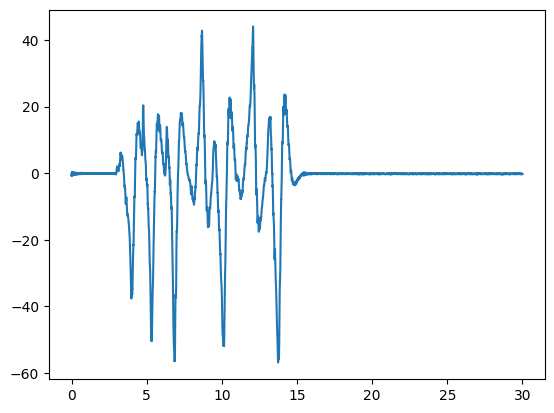

In [102]:
import utilities
import matplotlib.pyplot as plt

args = TCPArguments()
t_log = []
torque_log = []
# Create connection to the device and get the router
with utilities.DeviceConnection.createTcpConnection(args) as router, utilities.DeviceConnection.createUdpConnection(args) as router_real_time:

    torque_example = TorqueExample(router, router_real_time, 3.0)


    success = torque_example.InitCyclic(0.001, 30, True, torque_example.impedance_surface_bouncer)
    if success:
        while torque_example.cyclic_running:
            try:
                time.sleep(0.1)
            except KeyboardInterrupt:
                break

        torque_example.StopCyclic()
        t_log = torque_example.time_stamp_sec
        torque_log = torque_example._tau

# plot the torque
plt.plot(t_log, torque_log)

print("collision angle: ", torque_example.collision_angle)